In [ ]:
### First we have downloaded a net CDF from the Copernicus Data Store: https://cds.climate.copernicus.eu

### Changes to make:
- the complete table is saved here: data/generated/index_table_output
    - However, the file name should feature the start and end dates
- generate_etccdi_temporal_tables / generate_etccdi_temporal_tables__centroid
    - Do not print each graphic iteration 

In [1]:
import pandas as pd
import xarray as xr
from rasterstats import zonal_stats
import numpy as np

from utils.unzip import unzip_etccdi_package
from utils.correct_longitude import transform_longitudinal_values
from utils.give_metadata import give_metadata
from utils.temporal_index import find_etccdi_timeindex, translate_index_to_daterange
from utils.define_request import generate_and_validate_request

# Build API Request -----------------------------------------------------------------

from utils.cds_api_pull import pull_from_cds_api

# Methods ---------------------------------------------------------------------------
from utils.etccdi_to_pg__pointquery import generate_etccdi_temporal_tables__centroid
from utils.etccdi_to_pg import generate_etccdi_temporal_tables

# Validation ------------------------------------------------------------------------
from utils.give_reference_frame import provide_reference_frame
from utils.id_null_values import report_null_etccdi_values


## Access with Copernicus Data Store API:

### You must have both a Copernicus Data Store account and have followed the proceeding instructions on setting up the CDSAPI before you can retrieve and process data from this toolbox. 

#### The following instructions reference the CDSAPI set up guide: https://cds.climate.copernicus.eu/how-to-api


The final objective is to construct a main.py function that accepts the parameters below and automatically computes the process!

## API Request and Processing Parameters

### API Request Parameters
These parameters define the data retrieved via the API request:
- **`variable`**: Specifies the data variable of interest.
- **`product_type`**: Indicates the base product type.
- **`experiment`**: Defines the experimental setup or scenario.
- **`temporal_aggregation`**: Determines the temporal resolution of the data.

### Processing Parameters
These parameters guide the processing workflow:
- **`start_year`**: `'1995'`
- **`start_month`**: `'01'`
- **`end_year`**: `'2000'`
- **`end_month`**: `'12'`

### Method Selection
Choose a resampling or data alignment method:
- **Bilinear sampling**: Applies weighted interpolation for smoother results.
- **Point neighbor**: Maps the closest neighboring value preserving the original coarse resolution.

### (In Development) Extent Selection
Additional options for spatial analysis:
- Empirical distributions based on basin-specific extents.
- Future iterations will enable a 'hotspot' methodology for comparison with global metrics.


## Example of CDS Request

```
import cdsapi

dataset = "sis-extreme-indices-cmip6"
request = {
    "variable": ["cold_days"], 
    "product_type": ["base_period_1961_1990"],
    "model": ["hadgem3_gc31_ll"],
    "ensemble_member": ["r1i1p1f3"],
    "experiment": ["ssp1_2_6"],
    "temporal_aggregation": ["monthly"],
    "period": ["201501_210012"],
    "version": ["2_0"]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()
```   




In [2]:
p_variable="cold_days"
p_product_type="base_period_1961_1990"
p_experiment="ssp1_2_6"
p_temporal_aggregation="monthly"

#-----------------------------------------------------------
# Define Start Year & Month
#-----------------------------------------------------------
start_year = '2015'
start_month = '01'
#-----------------------------------------------------------
# Define End Year & Month
end_year = '2015'
end_month = '04'
#-----------------------------------------------------------
method = 'resample'
#-----------------------------------------------------------
country_selection = None


In [3]:
# Now, calling the function will generate and validate the request
request = generate_and_validate_request(
    variable=p_variable,
    product_type=p_product_type,
    experiment=p_experiment,
    temporal_aggregation=p_temporal_aggregation
)

display(request)

#-------------------------------------------------------------------
# Load a clean PG dataframe at a consistent temporal resolution
# to the request built
#-------------------------------------------------------------------

reference_df = provide_reference_frame(request)

Request is valid.


{'variable': ['cold_days'],
 'product_type': ['base_period_1961_1990'],
 'model': ['hadgem3_gc31_ll'],
 'ensemble_member': ['r1i1p1f3'],
 'experiment': ['ssp1_2_6'],
 'temporal_aggregation': ['monthly'],
 'period': ['201501_210012'],
 'version': ['2_0'],
 'data_format': 'netcdf'}

month_id         int64
priogrid_gid     int64
year            object
month           object
dtype: object


The zip_file_name will appear in folder:

```
CLIMATE_EXTREMES/
├── data/
│   ├── raw_external/
│   │   └── cds_zip/
```

In [4]:
zip_file_name = pull_from_cds_api(request)

2024-11-16 17:50:01,811 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-16 17:50:01,811 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-16 17:50:01,812 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-16 17:50:01,812 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

9f0470c6aaf8877934744b4712ced38e.zip:   0%|          | 0.00/109M [00:00<?, ?B/s]

The netcdf file will appear in folder: 

```
CLIMATE_EXTREMES/
├── data/
│   ├── generated/
│   │   └── netcd/

```

In [5]:
netcdf_file, etccdi_index = unzip_etccdi_package(zip_file_name)

tx10pETCCDI
Extracted file names: tx10pETCCDI_mon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_b1961-1990_v20200114_201501-210012_v2-0.nc


The adjusted netcdf file replaced the original file in location:

```
CLIMATE_EXTREMES/
├── data/
│   ├── generated/
│   │   └── netcd/
```

In [6]:
etccdi = transform_longitudinal_values(etccdi_index, netcdf_file)

The variable 'tx10pETCCDI' was found in the file path and the world continues to spin.
Original Latitude range: -89.375 to 89.375
Original Longitude range: 0.9375 to 359.0625
Adjusted Longitude range: -179.0625 to 179.0625
Adjusted dataset saved to: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/netcdf/adjusted_tx10pETCCDI_mon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_b1961-1990_v20200114_201501-210012_v2-0.nc.nc


In [7]:
give_metadata(etccdi)

Latitude range: -89.375 to 89.375
Longitude range: -179.0625 to 179.0625
Latitude resolution: 1.25
Longitude resolution: 1.875
Global Metadata:
CDI: Climate Data Interface version 1.8.0 (http://mpimet.mpg.de/cdi)
history: Tue Nov 24 09:31:53 2020: cdo mergetime tasmax_day_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150101-20491230.nc tasmax_day_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20500101-21001230.nc ./merged/tasmax_day_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150101-21001230.nc
2020-01-13T09:55:40Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.;
2020-01-13T09:53:59Z MIP Convert v1.2.3, Python v2.7.12, Iris v1.13.0, Numpy v1.13.3, netcdftime v1.4.1.
source: HadGEM3-GC31-LL (2016): 
aerosol: UKCA-GLOMAP-mode
atmos: MetUM-HadGEM3-GA7.1 (N96; 192 x 144 longitude/latitude; 85 levels; top level 85 km)
atmosChem: none
land: JULES-HadGEM3-GL7.1
landIce: none
ocean: NEMO-HadGEM3-GO6.0 (eORCA1 tripolar primarily 1 deg with meridional refinement down to 1/3 degree in the 

In [8]:
index_list, reference_filtered_time = translate_index_to_daterange(etccdi, reference_df, start_year, start_month, end_year, end_month)

Index of 01 data for year 2015: 0
Validation: Found data for Year: 2015, Month: 01 at index 0.

Index of 04 data for year 2015: 3
Validation: Found data for Year: 2015, Month: 04 at index 3.

The start index is: 0, referencing Month: 01 and Year: 2015

The end index is: 3, referencing Month: 04 and Year: 2015

         month_id  priogrid_gid  year month
5506200       421         62356  2015     1
5506201       421         79599  2015     1
5506202       421         79600  2015     1
5506203       421         79601  2015     1
5506204       421         80317  2015     1
...           ...           ...   ...   ...
5663515       432        190496  2015    12
5663516       432        190507  2015    12
5663517       432        190508  2015    12
5663518       432        190510  2015    12
5663519       432        190511  2015    12

[157320 rows x 4 columns]



ADF -- Rationalize why this is best:
    # Resample the raster data to the new resolution
    resampled_raster = raster_data.rio.reproject(
        raster_data.rio.crs,
        shape=(
            int(raster_data.shape[1] * 10),  # Increase number of rows by a factor of 10
            int(raster_data.shape[2] * 10)   # Increase number of columns by a factor of 10
        ),
        resampling=Resampling.bilinear  # Use the correct resampling method
    )


### Params:

- time_index_list,
- netcdf, climate_index, 
- shapefile_path



Raster files:
```
CLIMATE_EXTREMES/
├── data/
│   ├── generated/
│   │   └── index_raster_output/
```

Final output table:
```
CLIMATE_EXTREMES/
├── data/
│   ├── generated/
│   │   └── index_table_output/
```


In [ ]:
translated_filename = generate_etccdi_temporal_tables__centroid(index_list, etccdi, etccdi_index)

Processing time index: 0
Year: 2015 Month: 01
CRS is not set. Setting CRS to EPSG:4326
Original raster saved at: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_raster_output/native/original_tx10pETCCDI_2015_01.tif
Raster with nulls set to -9999 saved at: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_raster_output/native/null_set_tx10pETCCDI_2015_01.tif


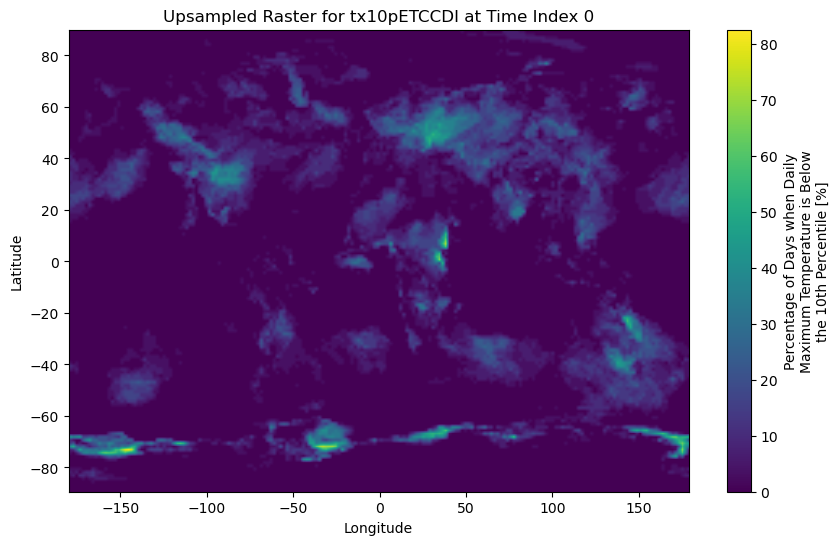

Upsampled raster saved at: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_raster_output/method/upsampled/upsampled_tx10pETCCDI_2015_01.tif


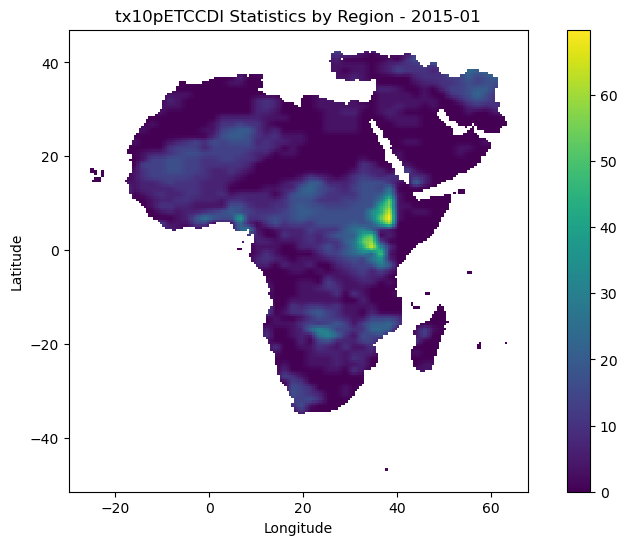

Processing time index: 1
Year: 2015 Month: 02
CRS is not set. Setting CRS to EPSG:4326
Original raster saved at: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_raster_output/native/original_tx10pETCCDI_2015_02.tif
Raster with nulls set to -9999 saved at: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_raster_output/native/null_set_tx10pETCCDI_2015_02.tif


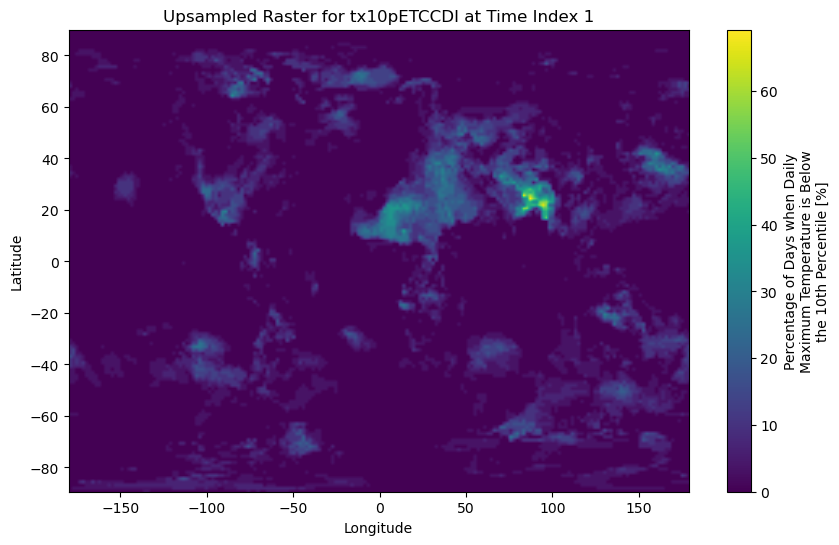

Upsampled raster saved at: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_raster_output/method/upsampled/upsampled_tx10pETCCDI_2015_02.tif


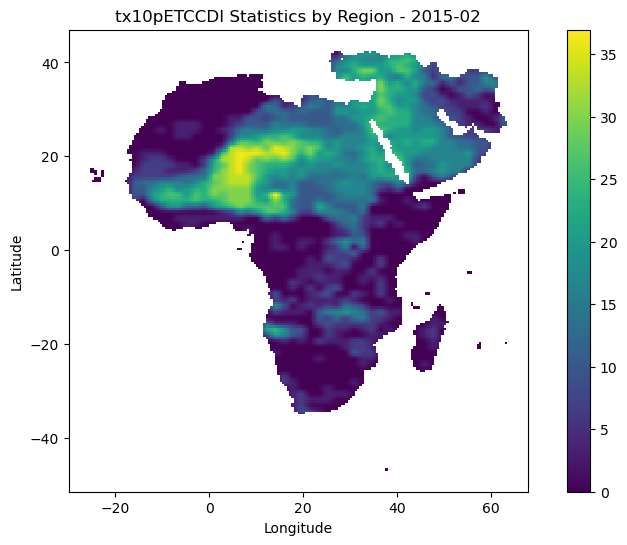

Processing time index: 2
Year: 2015 Month: 03
CRS is not set. Setting CRS to EPSG:4326
Original raster saved at: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_raster_output/native/original_tx10pETCCDI_2015_03.tif
Raster with nulls set to -9999 saved at: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_raster_output/native/null_set_tx10pETCCDI_2015_03.tif


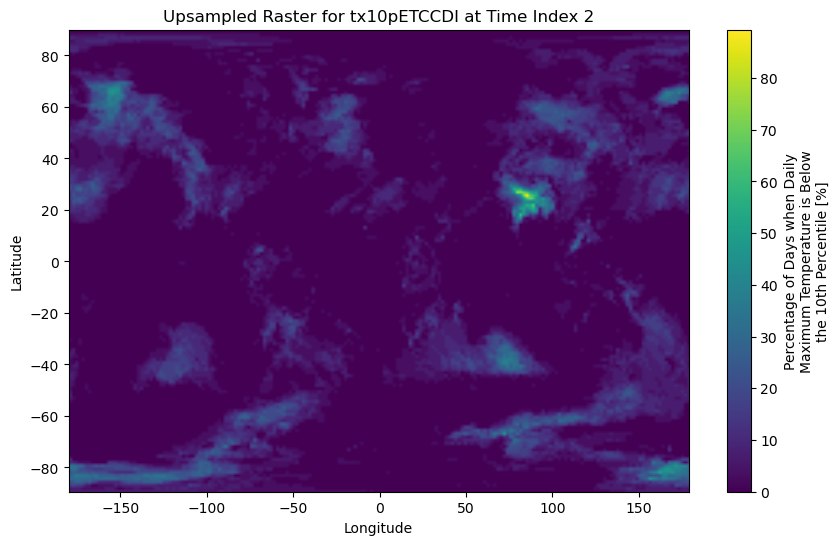

Upsampled raster saved at: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_raster_output/method/upsampled/upsampled_tx10pETCCDI_2015_03.tif


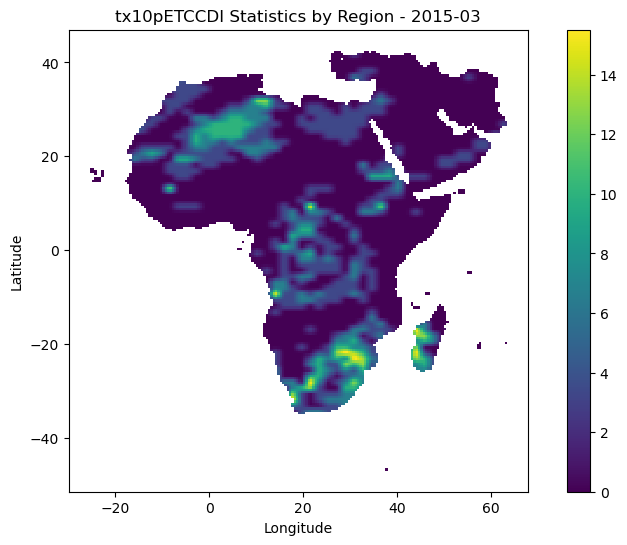

Processing time index: 3
Year: 2015 Month: 04
CRS is not set. Setting CRS to EPSG:4326
Original raster saved at: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_raster_output/native/original_tx10pETCCDI_2015_04.tif
Raster with nulls set to -9999 saved at: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_raster_output/native/null_set_tx10pETCCDI_2015_04.tif


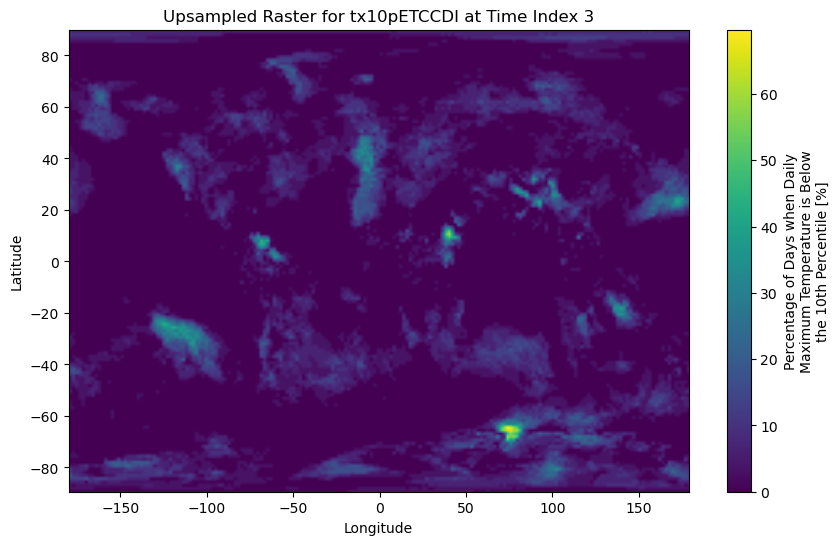

Upsampled raster saved at: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_raster_output/method/upsampled/upsampled_tx10pETCCDI_2015_04.tif


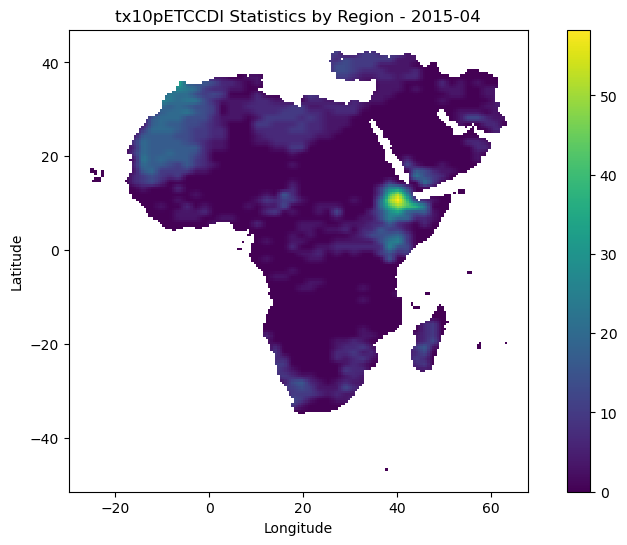

Final DataFrame saved to: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_table_output/tx10pETCCDI_0_3__resample.csv
All graphics saved to /Users/gbenz/Documents/Climate Data/climate_extremes/docs/Graphics/Standard_review/tx10pETCCDI_layout__resample.pdf


In [10]:
translated_filename = generate_etccdi_temporal_tables(index_list, etccdi, etccdi_index)

### Review:

#### Validate completeness of the output index at PG resolution:

Temporally: check that all total number of time periods match
- Spatially: Full extent of PG (for each temporal unit!)

How to do this:

1. Load the 'compiled' etccdi index .csv
2. check for null values

Total length should be: X

check length of temporal units should be: X (dependent on input parameters)
check length of spatial units should be: X

3. Plot the data

### What we need:

A complete 'clean' dataframe to reference from VIEWSER! 11.11


``translated_filename`` retrieves the summary table saved to:


``reference_filtered_time`` retrieves the primary reference table saved to:

In [11]:
report_null_etccdi_values(translated_filename, reference_filtered_time)

Total number of null values in 'validate_etccdi' DataFrame: 0
Total number of null values in 'validate_etccdi' DataFrame: 0
therefore, there is no null summary dataframe to report here!
